# package_LAB

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

import package_DBR
import package_LAB


from importlib import reload
package_LAB = reload(package_LAB)

from package_LAB import Lead_Lag_RT, calculate_pid
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

In [61]:
# Lead_Lag_RT

In [62]:
help(Lead_Lag_RT)

Help on function Lead_Lag_RT in module package_LAB:

Lead_Lag_RT(MV, Kp, T_lead, T_lag, Ts, PV, PVInit=0, method='EBD')
    Lead_Lag_RT(MV,Kp,T_lead,T_lag,Ts,PV,PVInit=0,method='EBD')
        The function "Lead_Lag_RT" needs to be included in a "for or while loop".

        :MV: input vector
        :Kp: process gain
        :T_lead: lead time constant [s]
        :T_lag: lag time constant [s]
        :Ts: sampling period [s]
        :PV: output vector
        :PVInit: (optional: default value is 0)
        :method: discretisation method (optional: default value is 'EBD')
            EBD: Euler Backward difference
            EFD: Euler Forward difference
            TRAP: Trapezoïdal method

        The function appends a value to the output vector "PV".
        The appended value is obtained from a recurrent equation that depends on the discretisation method.



(0.0, 100.0)

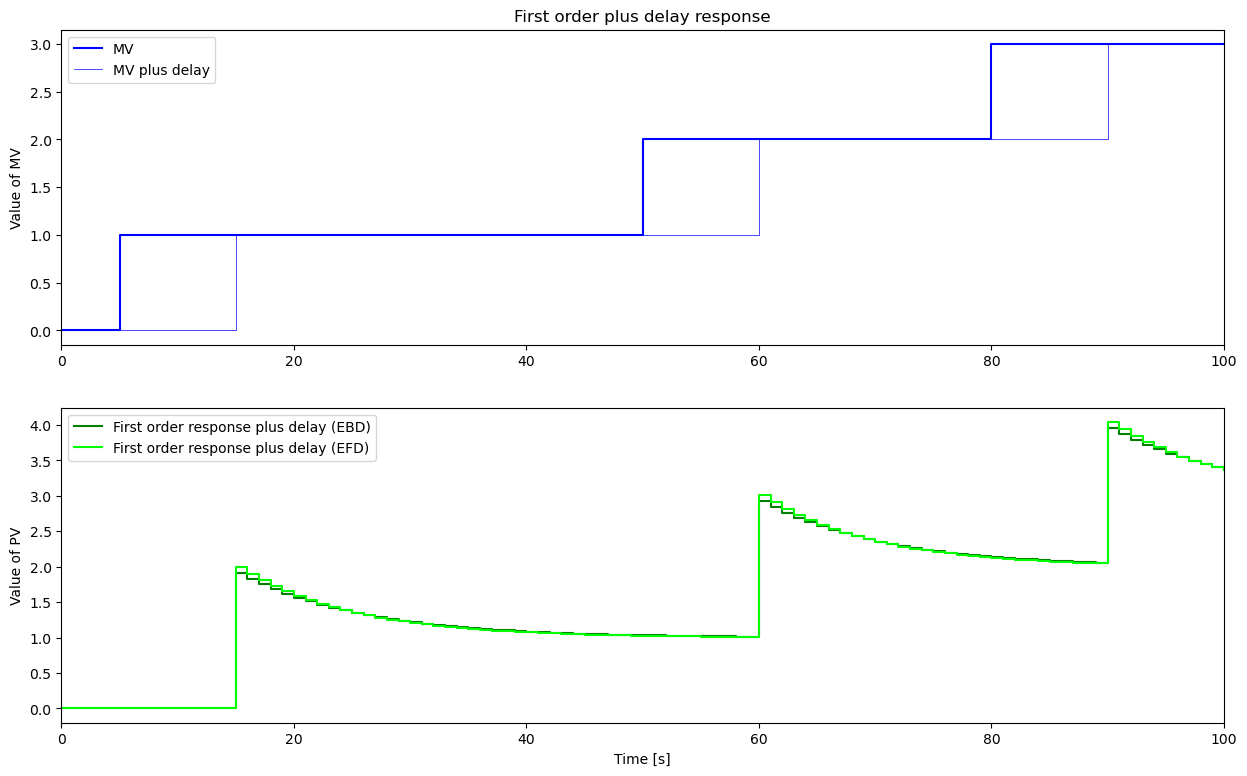

In [63]:
TSim = 100
Ts = 1
N = int(TSim/Ts) + 1

# Path for MV
MVPath = {0: 0, 5: 1, 50: 2, 80: 3, TSim: 3}

t = []
MV = []
MVDelay = []
PV_EBD = []
PV_EFD = []
PV_TRAP = []

# Parameters
Kp = 1
T_lead = 20
T_lag = 10
theta = 10

for i in range(0,N):
    t.append(i*Ts)
    SelectPath_RT(MVPath,t,MV)
    Delay_RT(MV,theta,Ts,MVDelay)
    Lead_Lag_RT(MVDelay,Kp,T_lead,T_lag,Ts,PV_EBD)
    Lead_Lag_RT(MVDelay,Kp,T_lead,T_lag,Ts,PV_EFD,0,'EFD')
    #Lead_Lag_RT(MVDelay,Kp,T_lead,T_lag,Ts,PV_TRAP,0,'TRAP')
    
plt.figure(figsize = (15,9))

plt.subplot(2,1,1)
plt.step(t,MV,'b-',label='MV',where='post')
plt.step(t,MVDelay,'b-',linewidth=0.5,label='MV plus delay',where='post')
plt.ylabel('Value of MV')
plt.title('First order plus delay response')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(2,1,2)
plt.step(t,PV_EBD,'g-',label='First order response plus delay (EBD)',where='post')
plt.step(t,PV_EFD,'lime',label='First order response plus delay (EFD)',where='post')
#plt.step(t,PV_TRAP,'springgreen',label='First order response plus delay (TRAP)',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])    

In [64]:
# PID Calculate

In [65]:
TSim = 250
N = 2500

SP = [0: 50, 5:60 , TSim: 60]
PV = [0:50, TSim :50]
MAN = [0:0, 100:1, 120:0, TSim: 0]

E = []
T_FD = 0.1
T_s = 0.1
T_I = 0.1
T_D = 0.1
K_C = 0.1

for i in range(0,N):
    t.append(i*T_s)
    SelectPath_RT(MVPath,t,MV)
    #Delay_RT(MV,theta,Ts,MVDelay)
    calculate_pid(E,T_FD,T_s,T_I,K_C,T_D,PV,SP)

plt.figure(figsize = (15,9))

plt.subplot(2,1,1)
plt.step(t,MV,'b-',label='MV',where='post')
plt.ylabel('Value of MV')
plt.title('First order plus delay response')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(2,1,2)
plt.step(t,PV,'g-',label='First order response plus delay (EBD)',where='post')
plt.ylabel('Value of PV')
plt.xlabel('Time [s]')
plt.legend(loc='best')
plt.xlim([0, TSim])


SyntaxError: invalid syntax (1727442998.py, line 4)